# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable
from ipywidgets import interact

pd.options.mode.copy_on_write = True

In [3]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [4]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )

MASSIVE_RT_REVIEW_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movie_reviews.csv",
                               "Massive Rotten Tomatoes Reviews",
                               "Dataset containing ~1.4M+ reviews from RT",                               
                               {
                                    "id": "Unique identifier for each movie (matches the ID in the movies dataset).",
                                    "reviewId": "Unique identifier for each critic review.",
                                    "creationDate": "The date the review was published.",
                                    "criticName": "Name of the critic who wrote the review.",
                                    "isTopCritic": "Indicates if the critic is considered a 'Top Critic' (True or False).",
                                    "originalScore": "The score provided by the critic.",
                                    "reviewState": "The status of the review (e.g., 'fresh', 'rotten').",
                                    "publicatioName": "The name of the publication where the review was published.",
                                    "reviewText": "The full text of the critic review.",
                                    "scoreSentiment": "The sentiment of the critic's score (e.g., 'positive', 'negative', 'neutral').",
                                    "reviewUrl": "The url of the review"
                                }
                            )

RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,MASSIVE_RT_REVIEW_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [5]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 7 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Massive Rotten Tomatoes Reviews, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [6]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [7]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

## I- Popularity analysis

##

In [8]:
def preprocessing_rt_rev_ds():
    reviews_df = MASSIVE_RT_REVIEW_DS.df.copy()
    movies_df = MASSIVE_RT_MOVIE_DS.df.copy()
    
    print(f"Reviews Dataset: {reviews_df.shape[0]} rows, {reviews_df.shape[1]} columns")
    print(f"Movies Dataset: {movies_df.shape[0]} rows, {movies_df.shape[1]} columns")
    
    # Merge the datasets on 'id'
    combined_df = pd.merge(reviews_df, movies_df, on="id", how="inner")
    print(f"Combined Dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
    return combined_df

In [9]:
combined_df = preprocessing_rt_rev_ds()

Reviews Dataset: 1444963 rows, 11 columns
Movies Dataset: 143258 rows, 16 columns
Combined Dataset: 1469543 rows, 26 columns


In [10]:
def display_chart(movie):
    # Used to display an interactive chart -- given a movie, 
    # gets the expert and non-expert rating
    
    movie_data = combined_df[combined_df['title'].str.lower() == movie.lower()]
    
    if movie_data.empty:
        print("Movie not found. Try another title.")
        return
    else:
      
        scores = {}
        if pd.notna(movie_data['audienceScore'].values[0]):
            scores['Audience Score'] = movie_data['audienceScore'].values[0]
        if pd.notna(movie_data['tomatoMeter'].values[0]):
            scores['Tomatometer'] = movie_data['tomatoMeter'].values[0]
        
     
        if not scores:
            print("No scores available for this movie.")
            return
        
    
        is_comedy = movie_data['genre'].str.contains('Comedy', case=False, na=False).values[0]


        bar_colors = [COLOR_PALETTE[4], COLOR_PALETTE[2]] if is_comedy else [COLOR_PALETTE[1], COLOR_PALETTE[3]]

        labels = list(scores.keys())
        values = list(scores.values())
        
        _, ax = plt.subplots(figsize=(8, 5))
        
      
        bars = ax.bar(labels, values, color=bar_colors[:len(values)])
        

        for bar, score in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, 
                    f'{score}%', ha='center', va='bottom', fontsize=12, color='black')
        
        #Title (comedy or not)
        genre_info = "(Comedy)" if is_comedy else "(Non-Comedy)"
        ax.set_title(f'Scores for "{movie}" {genre_info}', fontsize=14)
        ax.set_xlabel('Score Type', fontsize=12)
        ax.set_ylabel('Score (%)', fontsize=12)
        
        plt.tight_layout()
        plt.show()

interact(display_chart, movie="love")

interactive(children=(Text(value='love', description='movie'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_chart(movie)>

In [11]:
def filter_comedy_review():
    return combined_df[combined_df['genre'].str.contains('Comedy', case=False, na=False)]


In [12]:
def most_frequent_comedy_genre():
    comedy_df = filter_comedy_review()
    
    if 'genre' not in comedy_df.columns:
        print("Error: 'genre' column not found in comedy_df")
        return
    
    associated_genres = []
    for genre_list in comedy_df['genre'].str.lower().str.split(',\s*'):
        if isinstance(genre_list, list):
            # Add all genres except "comedy" to the temporary list
            associated_genres.extend([genre for genre in genre_list if genre != "comedy"])

    associated_genre_counts = pd.Series(associated_genres).value_counts()

    print(associated_genre_counts.head(10))

    fig, ax = plt.subplots(figsize=(10, 6))

    associated_genre_counts.head(10).plot(kind='bar', color=COLOR_PALETTE[:10], ax=ax)

    ax.set_title('Most Frequent Genres Associated with "Comedy"', fontsize=14)
    ax.set_xlabel('Associated Genre', fontsize=12)
    ax.set_ylabel('Number of Movies', fontsize=12)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Removille\AppData\Local\Temp\ipykernel_10604\218771490.py:9: SyntaxWarning: invalid escape sequence '\s'
  for genre_list in comedy_df['genre'].str.lower().str.split(',\s*'):


drama                 141631
romance                72762
adventure              58692
kids & family          54773
action                 38820
fantasy                37199
animation              36024
mystery & thriller     20966
horror                 18253
musical                12936
Name: count, dtype: int64


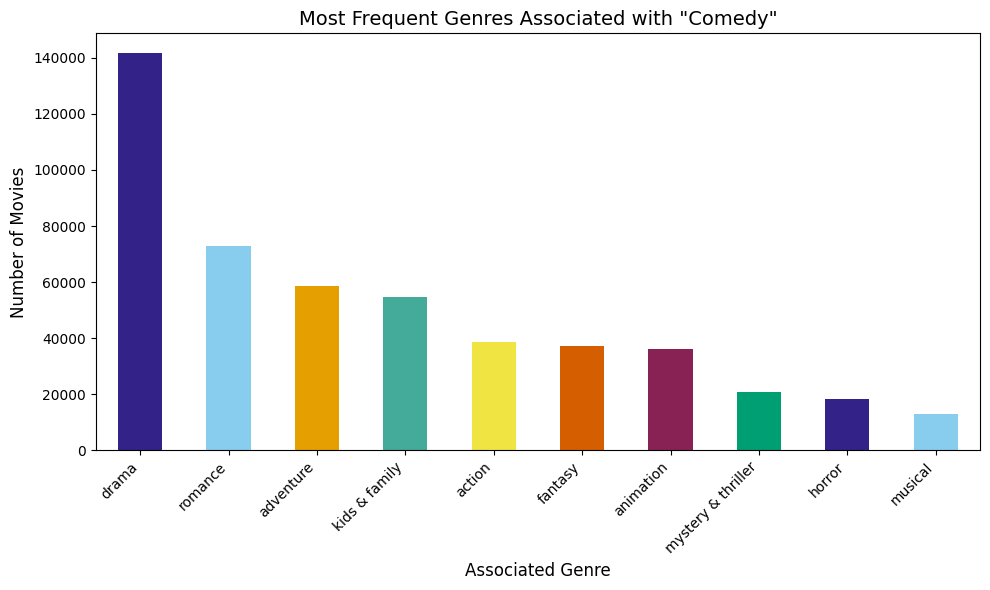

In [13]:
most_frequent_comedy_genre()

## II. Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


In [14]:
useful_col = ['wikipedia_id','title','box_office_revenue','genres']
unfiltered_df_box_office = CMU_MOVIES_DS.df[useful_col].copy()
df_box_office = unfiltered_df_box_office[unfiltered_df_box_office['genres'].str.contains('comedy', case=False, na=False)]
count_na = df_box_office['box_office_revenue'].isna().sum()
print(count_na/len(df_box_office))

0.8392791297935103


In the initial dataset the number of missing box-office values is very high, about 84% of the movies are missing a box-office value.

Standardizing the movie names is necessary to improve the accuracy of the merges between the different dataframes. 

In [15]:
def standardize_title(title):
    if not isinstance(title, str):
        return None
    title = title.lower()
    title = re.sub(r'[^a-z0-9\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df_raw_rt_rev = MASSIVE_RT_REVIEW_DS.df.copy()
df_raw_rt = MASSIVE_RT_MOVIE_DS.df.copy()

df_short_rt = df_raw_rt_rev[["id","isTopCritic","originalScore","scoreSentiment"]]
df_id_title = df_raw_rt[["id","title"]]

In [16]:
merged_raws = pd.merge(df_id_title, df_short_rt, on= "id", how="inner")

merged_raws["title"] = merged_raws["title"].apply(standardize_title)
df_box_office["title"] = df_box_office["title"].apply(standardize_title)

merge_big_dfs = pd.merge(df_box_office, merged_raws, on='title', how='inner')
merge_big_dfs = merge_big_dfs.drop_duplicates()
merge_big_dfs = merge_big_dfs[merge_big_dfs["originalScore"].notna()].copy()
df_expert_critics = merge_big_dfs[merge_big_dfs["isTopCritic"]==True]
list_movies = df_expert_critics["title"].unique() 
print(f"Number of comedies : {len(list_movies)}")

Number of comedies : 5340


The merge of the initial dataset with the 'big' Rotten tomatoes one gives an exploitable dataset : 5340 comedies with critic score and reviews. There are still some missing values (=NaN) on the box office column from the initial dataset, these missing values will be completed with another dataset.

In [17]:
df_plot = CMU_PLOTS_DS.df
df_1st_plot = CMU_PLOTS_DS.df.head(5)

In [18]:
from llmware.agents import LLMfx

def get_one_sentiment_classification(text):
    agent = LLMfx(verbose=True)
    agent.load_tool("sentiment")
    sentiment = agent.sentiment(text)
    
    sentiment_value = sentiment["llm_response"]["sentiment"]
    confidence_level = sentiment["confidence_score"]
    
    print("Plot:", text)
    print("Sentiment:", sentiment_value)
    print("Confidence level", confidence_level)
    
    return sentiment_value, confidence_level

# Application of the analysis on the plots
df_1st_plot[['Sentiment', 'Confidence']] = df_1st_plot['plot'].swifter.apply(
    lambda x: pd.Series(get_one_sentiment_classification(x))
)


ModuleNotFoundError: No module named 'llmware'

The computation of the sentiment analysis for the first 5 plots of the dataset takes 2min34s. We linearize this values using the number of words in the 5 plots and the number of words in all the comedy plots : 

In [20]:
df_merge_IDs = pd.merge(df_box_office, df_plot, on='wikipedia_id', how='inner')

time = 154
words = ' '.join(df_1st_plot["plot"]).split()
words_comedy = ' '.join(df_merge_IDs["plot"]).split()
computation_time = ((len(words_comedy)/len(words))*time)/(24*3600)
print(f"Linear estimation of the computation time for all the comedy plot summaries: {computation_time} days")


Linear estimation of the computation time for all the comedy plot summaries: 2.8842083242377936 days


We have a computation time of about 3 days which is quite long, this computation time can probably be optimized later. This part of the code only has to be ran once, the results would be saved.

## III. Per-genre analysis 

As this section neither requires any additional datasets, nor does it use any different type of techniques, we do no provide a sample Proof of Concept for it. The final analysis will be ready for P3! 

## IV. Cultural differences

In [19]:
print(f"Preprocessing CMU dataset...")
cmu_cleaned_movies = prepro_cmu_movies(CMU_MOVIES_DS.df)
print(f"Preprocessed CMU dataset!")

Preprocessing CMU dataset...


Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Preprocessed CMU dataset!


In [20]:
total_movies_per_year = cmu_cleaned_movies.groupby('release_date').size().reset_index(name='movie_count')
def get_comedies_mask(df):
    # Returns the (boolean) comedy mask for the given df
    # The `df` has to be of similar format as `prepro_cmu_movies(CMU_MOVIES_DS.df)`
    return df["genres"].apply(lambda genre_list: "Comedy" in genre_list or "comedy" in genre_list)
cmu_comedies = cmu_cleaned_movies[get_comedies_mask(cmu_cleaned_movies)]
comedy_count_by_year = cmu_comedies.groupby('release_date').size().reset_index(name='comedy_count')

movies_per_year = pd.merge(total_movies_per_year, comedy_count_by_year, on='release_date', how='left')
movies_per_year['comedy_count'] = movies_per_year['comedy_count'].fillna(0)
    
movies_per_year['comedy_proportion'] = movies_per_year['comedy_count'] / movies_per_year['movie_count']

movies_per_year = movies_per_year[movies_per_year['release_date'] >= 1900]


In [92]:
print(len(cmu_cleaned_movies))
cmu_cleaned_movies.head()

81741


,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama]


In [93]:
oscar_awards = OSCAR_AWARDS_DS.df
print(len(oscar_awards))
oscar_awards.rename(columns={'film':'title', 'year_film':'release_date'}, inplace = True)
oscar_awards.head()

10889


,release_date,year_ceremony,ceremony,category,name,title,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [113]:
movies_awards = (cmu_cleaned_movies.copy()).merge(oscar_awards, on=['title']).drop(columns=['release_date_x'])
movies_awards = movies_awards.rename(columns={'release_date_y':'release_date'})
print(len(movies_awards))
movies_awards.head()

12434


,wikipedia_id,freebase_id,title,box_office_revenue,runtime,languages,countries,genres,release_date,year_ceremony,ceremony,category,name,winner
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,ART DIRECTION,"Bernard Herzbrun, Boris Leven",False
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,FILM EDITING,Barbara McLean,False
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,MUSIC (Scoring),Alfred Newman,True
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,MUSIC (Song),Music and Lyrics by Irving Berlin,False
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,OUTSTANDING PRODUCTION,20th Century-Fox,False


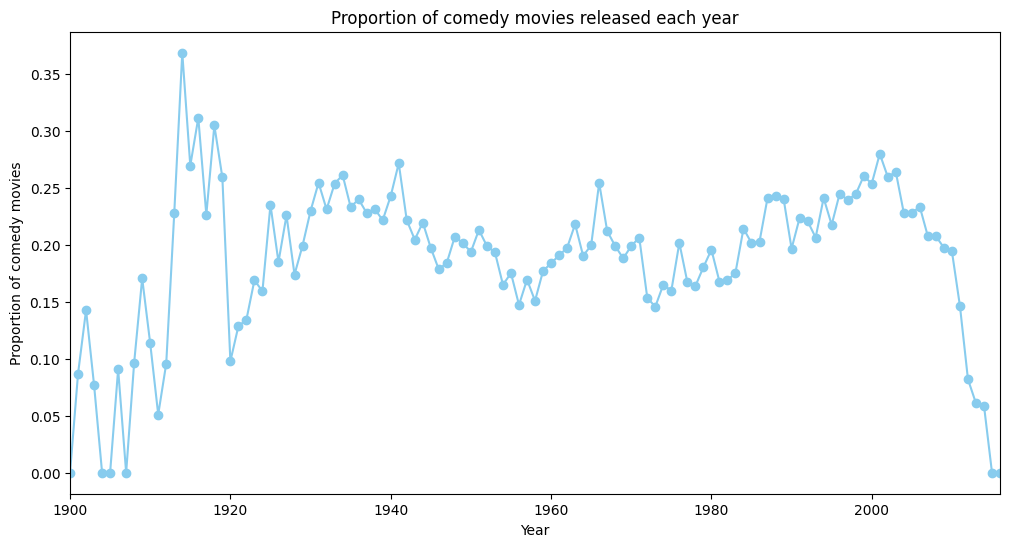

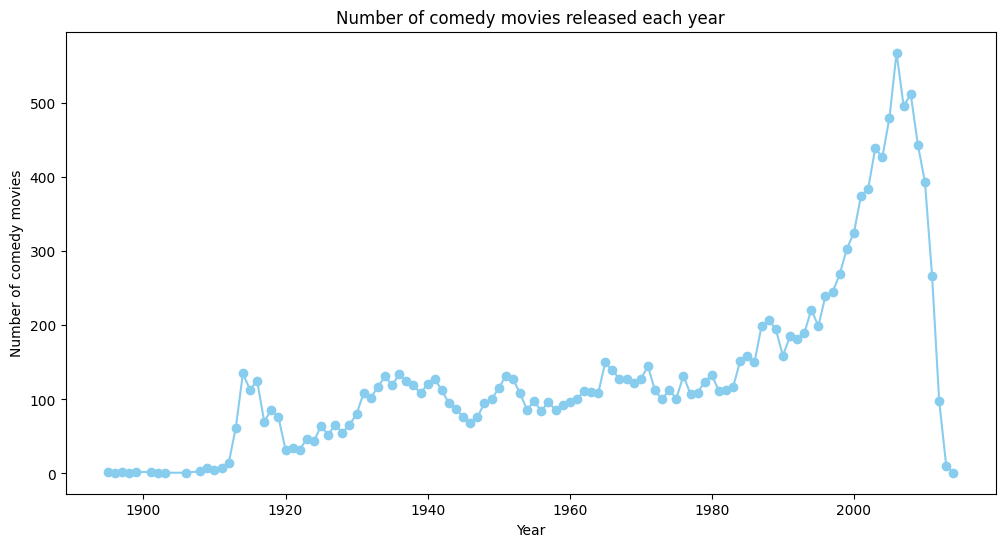

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(movies_per_year['release_date'], movies_per_year['comedy_proportion'], marker='o', color=COLOR_PALETTE[1], linestyle='-')
plt.title('Proportion of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Proportion of comedy movies')
plt.xlim(movies_per_year['release_date'].min(), movies_per_year['release_date'].max())

plt.figure(figsize=(12, 6))
plt.plot(comedy_count_by_year['release_date'], comedy_count_by_year['comedy_count'], marker='o', color=COLOR_PALETTE[1], linestyle='-')
plt.title('Number of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Number of comedy movies')

plt.show()

In [25]:
movies_exploded_countries = cmu_cleaned_movies.explode(column="countries")
movies_exploded_countries["is_comedy"] = get_comedies_mask(movies_exploded_countries)
country_movie_counts = movies_exploded_countries.groupby('countries').agg(
    total_movies=('countries', 'size'),
    comedy_movies=('is_comedy', 'sum')
).reset_index()

print(country_movie_counts)

           countries  total_movies  comedy_movies
0        Afghanistan            15              0
1            Albania            28              2
2            Algeria            43              1
3          Argentina          1468            268
4            Armenia            16              3
..               ...           ...            ...
142  Weimar Republic            68              7
143     West Germany           647             93
144       Yugoslavia           306             41
145           Zambia             3              0
146         Zimbabwe             8              2

[147 rows x 3 columns]


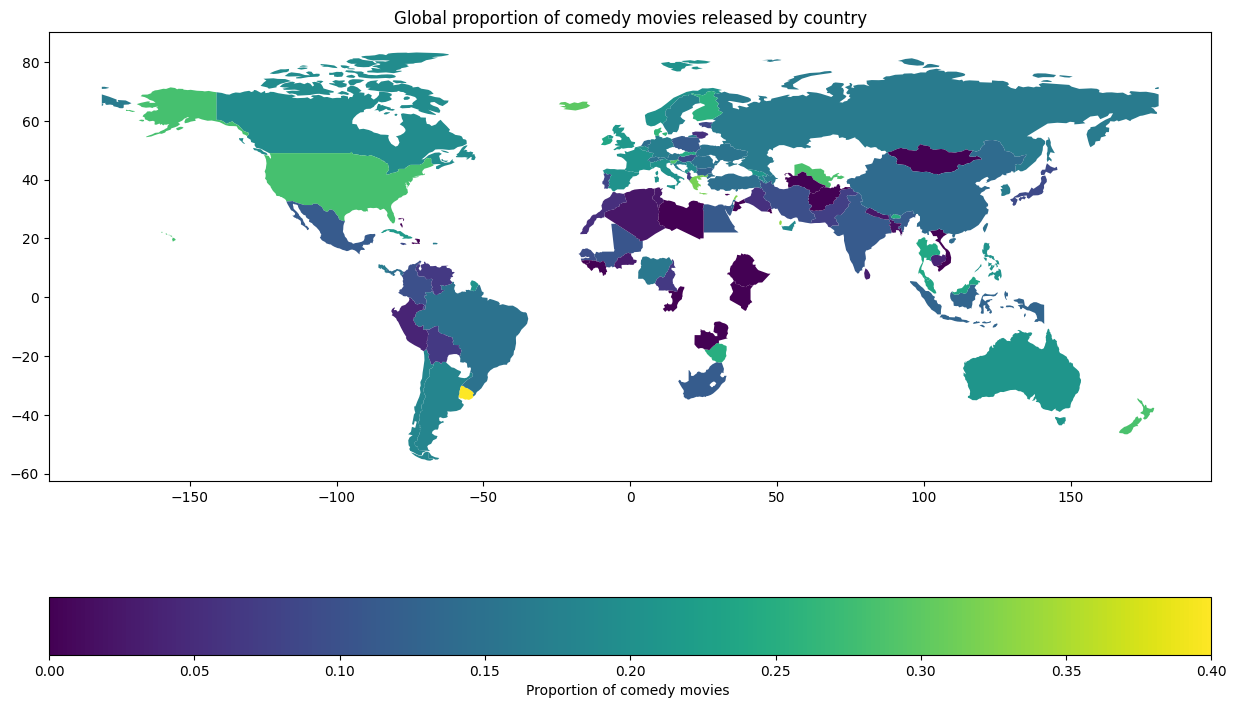

In [81]:
country_movie_counts['comedy_proportion'] = country_movie_counts['comedy_movies'] / country_movie_counts['total_movies']

world = gpd.read_file(RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

world_comedy = world.set_index('NAME').join(country_movie_counts.set_index('countries'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_comedy.plot(column='comedy_proportion', ax=ax, legend=True,
                 legend_kwds={'label': "Proportion of comedy movies ",
                              'orientation': "horizontal"})
plt.title('Global proportion of comedy movies released by country')
plt.show()

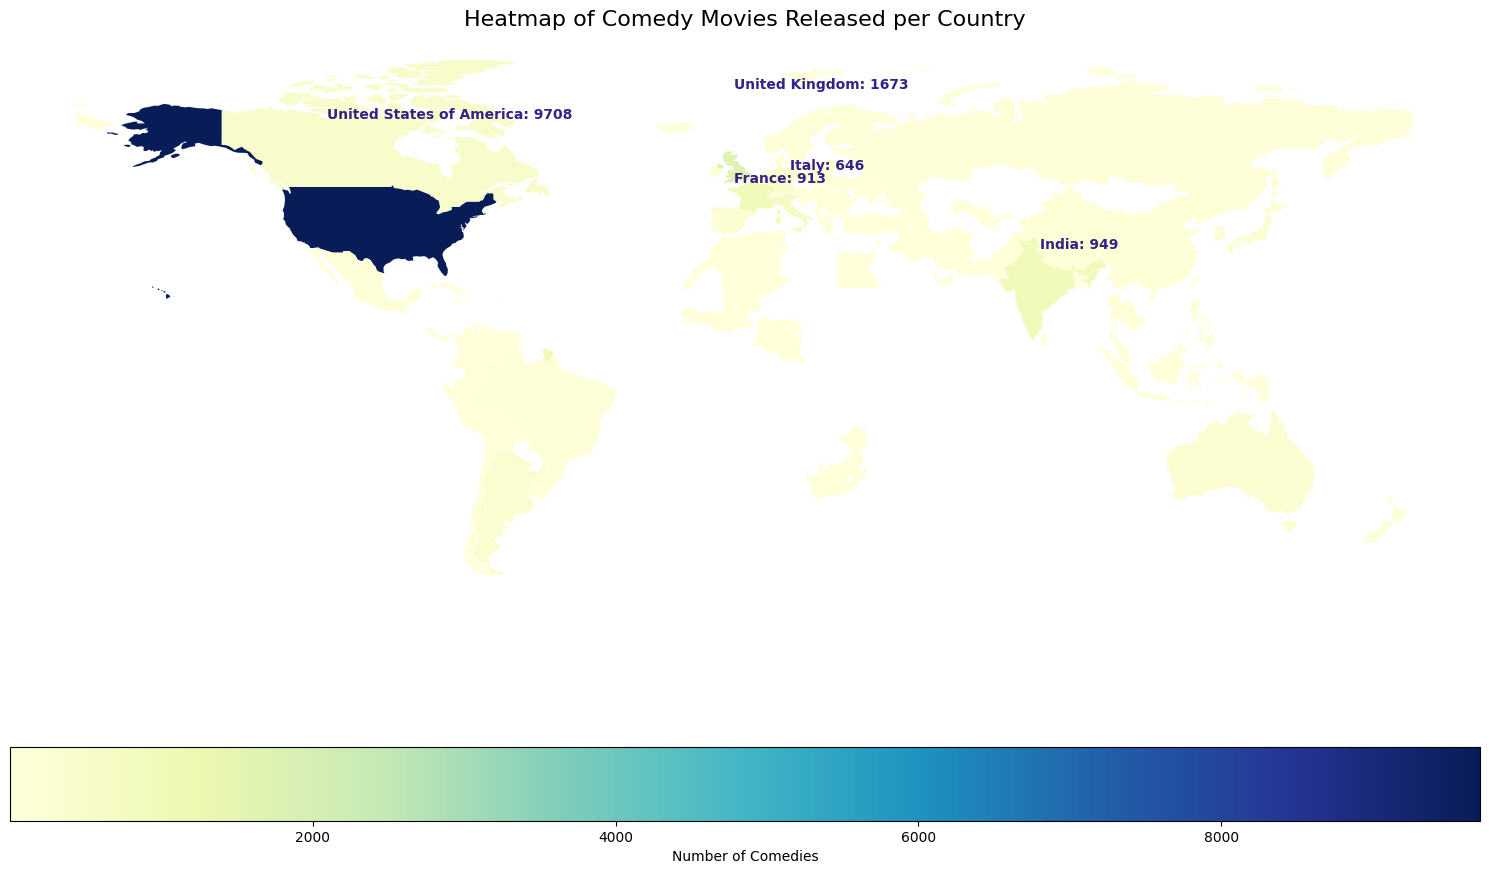

In [83]:
comedies_per_country = cmu_comedies.explode(column="countries")
comedies_count_by_country = comedies_per_country.groupby('countries').agg(
    comedy_count=('title', 'count')
).reset_index()
world = gpd.read_file(RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world_comedy = world.set_index('NAME').join(comedies_count_by_country.set_index('countries'))
top_5_countries = comedies_count_by_country.nlargest(5, 'comedy_count')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_comedy.plot(
    column='comedy_count',     
    cmap='YlGnBu',              
    ax=ax,
    legend=True,                
    legend_kwds={
        'label': "Number of Comedies",
        'orientation': "horizontal"
    }
)

for i, row in top_5_countries.iterrows():
    country_row = world_comedy.loc[row['countries']]
    if not pd.isna(country_row['geometry']):
        offset = i*(0.2)
        plt.text(
            country_row.geometry.centroid.x,
            country_row.geometry.centroid.y + offset,
            f"{row['countries']}: {int(row['comedy_count'])}", 
            fontsize=10, 
            color=COLOR_PALETTE[0], 
            fontweight='bold', 
            va='bottom',
            ha='left'
        )

plt.title('Heatmap of Comedy Movies Released per Country', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

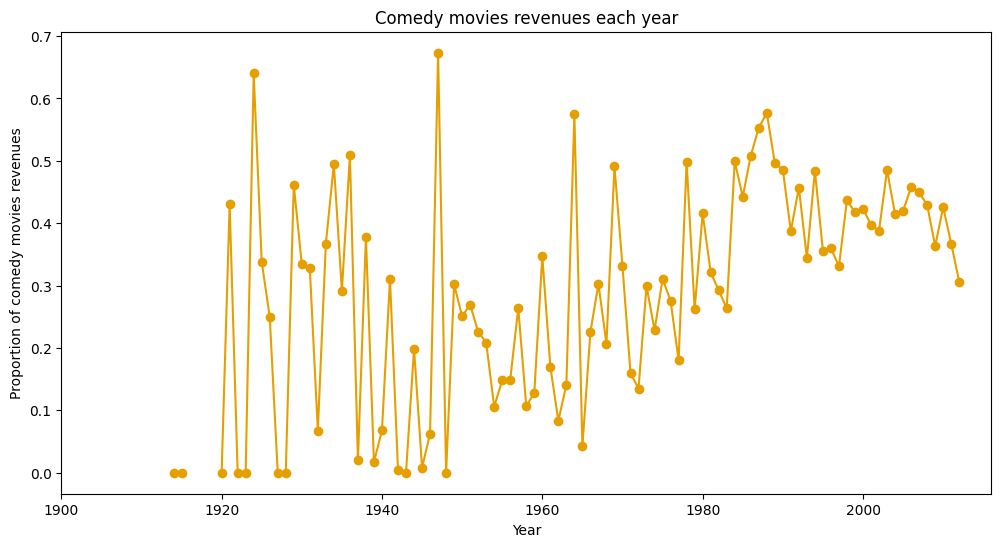

In [64]:
total_revenues_per_year = cmu_cleaned_movies.groupby('release_date')['box_office_revenue'].sum().reset_index(name='total_revenue')
comedy_revenues_by_year = cmu_comedies.groupby('release_date')['box_office_revenue'].sum().reset_index(name='comedy_revenue')

revenues_per_year = pd.merge(total_revenues_per_year, comedy_revenues_by_year, on='release_date', how='left')
revenues_per_year['comedy_revenue'] = revenues_per_year['comedy_revenue'].fillna(0)
revenues_per_year['comedy_revenue'] = revenues_per_year['comedy_revenue'] / revenues_per_year['total_revenue']

# Filter
revenues_per_year = revenues_per_year[revenues_per_year['release_date'] >= 1900]


plt.figure(figsize=(12, 6))
plt.plot(revenues_per_year['release_date'], revenues_per_year['comedy_revenue'], marker='o', color=COLOR_PALETTE[2], linestyle='-')
plt.title('Comedy movies revenues each year')
plt.xlabel('Year')
plt.ylabel('Proportion of comedy movies revenues')
plt.xlim(revenues_per_year['release_date'].min(), revenues_per_year['release_date'].max())

plt.show()

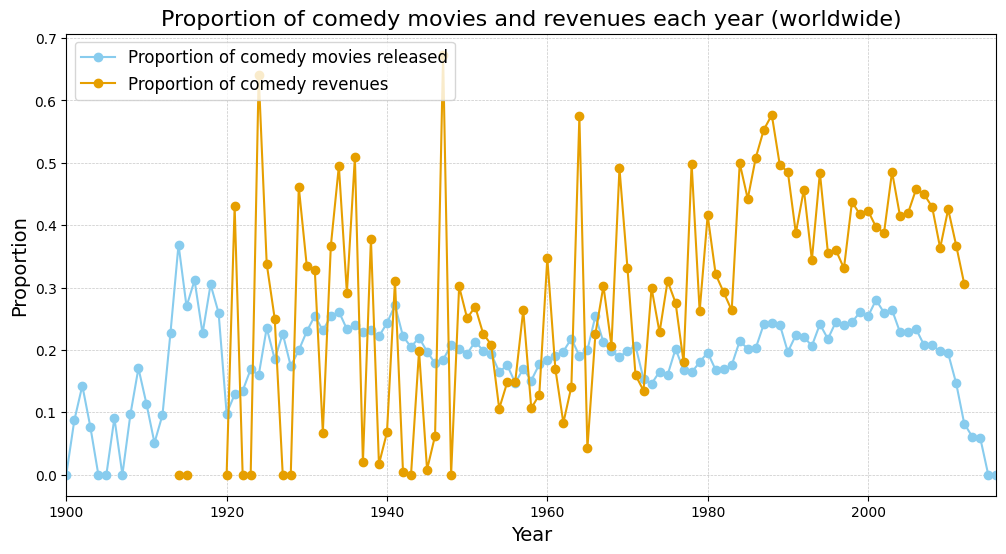

In [65]:
plt.figure(figsize=(12, 6))

plt.plot(movies_per_year['release_date'], movies_per_year['comedy_proportion'], 
         marker='o', color=COLOR_PALETTE[1], linestyle='-', label='Proportion of comedy movies released')
plt.plot(revenues_per_year['release_date'], revenues_per_year['comedy_revenue'], 
         marker='o', color=COLOR_PALETTE[2], linestyle='-', label='Proportion of comedy revenues')

plt.title('Proportion of comedy movies and revenues each year (worldwide)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlim(movies_per_year['release_date'].min(), movies_per_year['release_date'].max())

plt.show()

In [117]:
comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]
print(len(comedy_movies))
comedy_movies = comedy_movies.explode('countries')
country_analysis = comedy_movies.groupby(['countries', 'winner']).size().reset_index(name='count')
country_pivot = country_analysis.pivot(index='countries', columns='winner', values='count').fillna(0)
country_pivot.columns = ['Non_Winning_Comedies', 'Winning_Comedies']
country_pivot['Total_Comedies'] = country_pivot['Non_Winning_Comedies'] + country_pivot['Winning_Comedies']
country_pivot['Winning_Percentage'] = (country_pivot['Winning_Comedies'] / country_pivot['Total_Comedies'])*100
country_pivot['Winning_Percentage'] = country_pivot['Winning_Percentage'].replace([float('inf'), float('nan')], 0)
country_pivot_sorted = country_pivot.sort_values(by='Winning_Percentage', ascending=False)
country_pivot_sorted.head(10)

2295


,Non_Winning_Comedies,Winning_Comedies,Total_Comedies,Winning_Percentage
countries,,,,
Azerbaijan,0.0,1.0,1.0,100.000000
Soviet Union,0.0,1.0,1.0,100.000000
Switzerland,0.0,1.0,1.0,100.000000
Russia,0.0,1.0,1.0,100.000000
Slovenia,0.0,1.0,1.0,100.000000
Zimbabwe,1.0,2.0,3.0,66.666667
New Zealand,2.0,3.0,5.0,60.000000
Scotland,1.0,1.0,2.0,50.000000
Bosnia and Herzegovina,1.0,1.0,2.0,50.000000


In [121]:
comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]
print(len(comedy_movies))

comedy_movies2 = cmu_cleaned_movies[cmu_cleaned_movies['genres'].apply(lambda genres: 'Comedy' in genres)]
print(len(comedy_movies2))

2295
16349


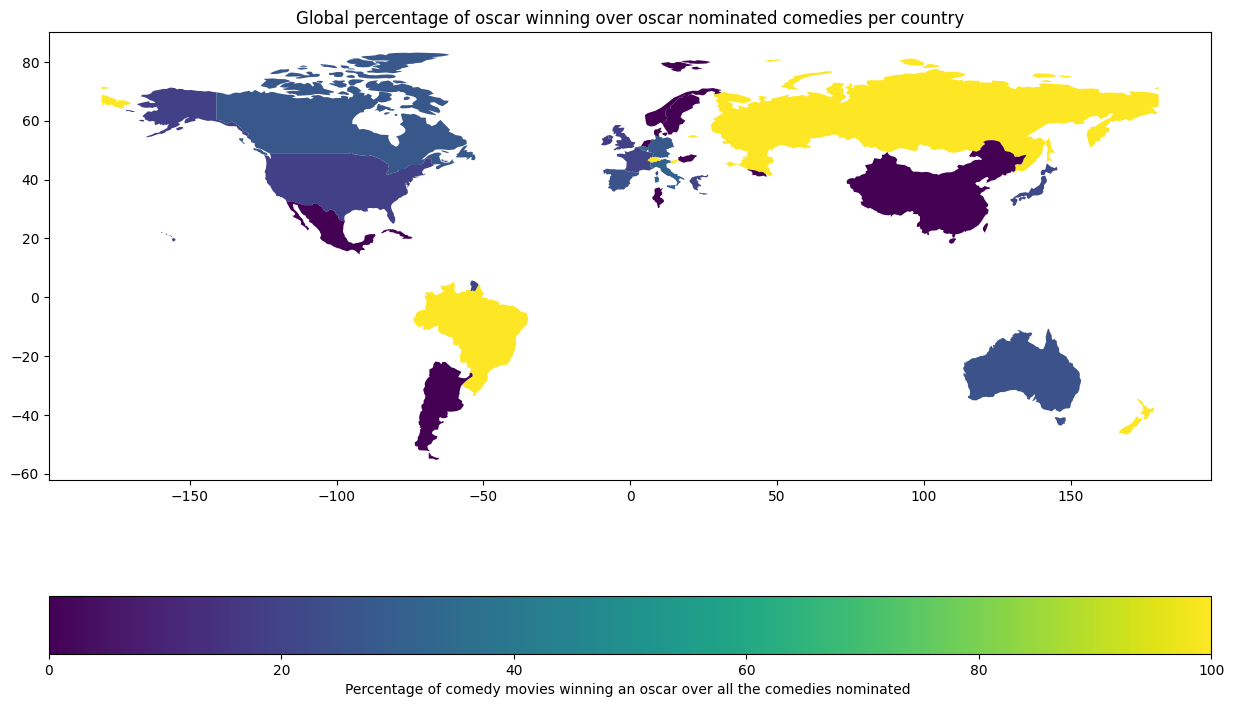

In [31]:
country_pivot_sorted = country_pivot_sorted.reset_index()
world = gpd.read_file(RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

world_comedy = world.set_index('NAME').join(country_pivot_sorted.set_index('countries'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_comedy.plot(column='Winning_Percentage', ax=ax, legend=True,
                 legend_kwds={'label': "Percentage of comedy movies winning an oscar over all the comedies nominated ",
                              'orientation': "horizontal"})
plt.title('Global percentage of oscar winning over oscar nominated comedies per country')
plt.show()

In [124]:
winning_movies = movies_awards[movies_awards['winner'] == True]
print(len(winning_movies))
winning_movies = winning_movies.explode('countries')
total_award_winning = winning_movies.groupby('countries').size().reset_index(name='Winning_Movies_Total')
winning_comedies = winning_movies[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]
print(len(winning_comedies))
comedy_award_winning = winning_comedies.groupby('countries').size().reset_index(name='Winning_Comedies')

country_comparison = total_award_winning.merge(comedy_award_winning, on='countries', how='outer').fillna(0)
country_comparison['Winning_Movies_Total'] = country_comparison['Winning_Movies_Total'].astype(int)
country_comparison['Winning_Comedies'] = country_comparison['Winning_Comedies'].astype(int)

country_comparison['Comedy_Percentage'] = (country_comparison['Winning_Comedies'] / 
                                           country_comparison['Winning_Movies_Total']) * 100
country_comparison['Comedy_Percentage'] = country_comparison['Comedy_Percentage'].fillna(0)

country_comparison = country_comparison.sort_values(by='Comedy_Percentage', ascending=False)

country_comparison = country_comparison.sort_values(by='Winning_Movies_Total', ascending=False)
country_comparison.head()


2745
569


C:\Users\Removille\AppData\Local\Temp\ipykernel_10604\338577746.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  winning_comedies = winning_movies[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]


,countries,Winning_Movies_Total,Winning_Comedies,Comedy_Percentage
58,United States of America,2026,379,18.706811
57,United Kingdom,449,49,10.913140
17,France,153,30,19.607843
19,Germany,125,20,16.000000
8,Canada,74,11,14.864865


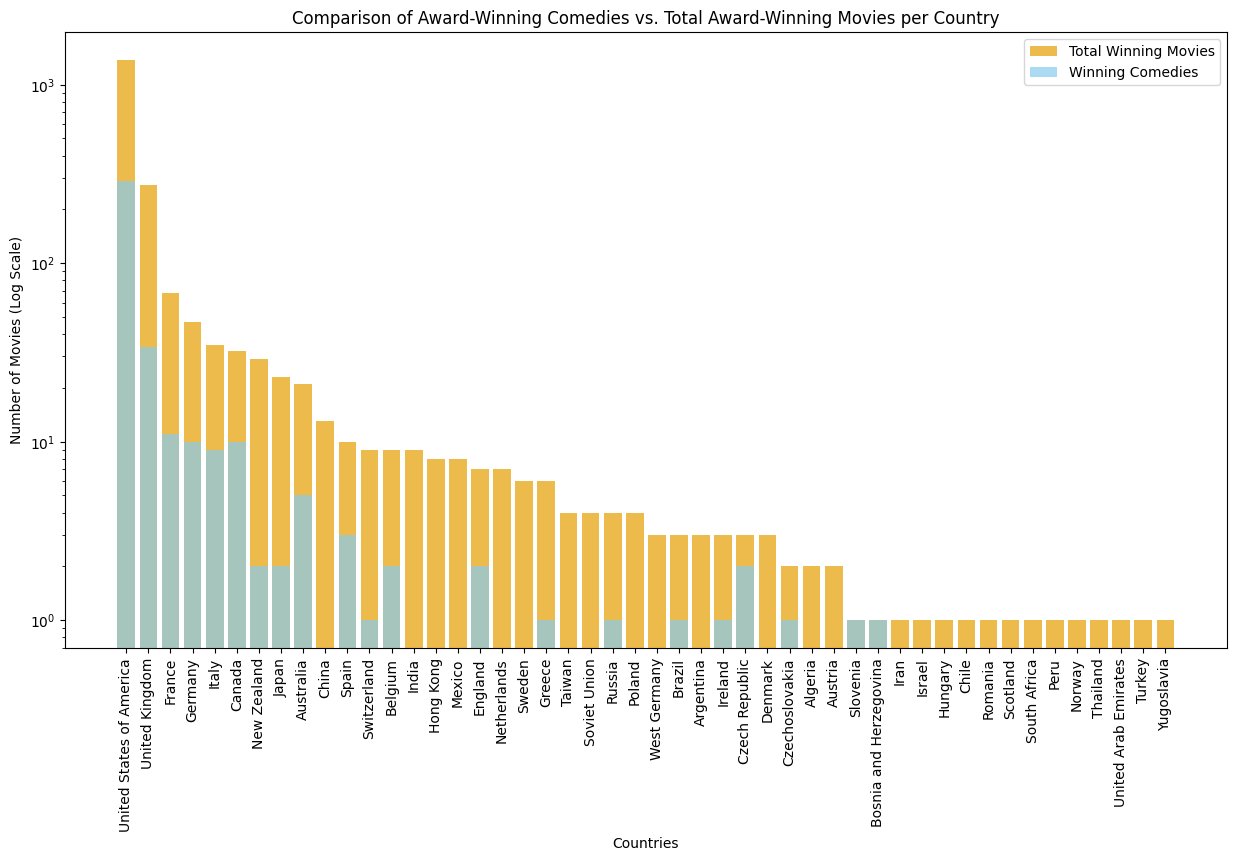

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(country_comparison['countries'], country_comparison['Winning_Movies_Total'], label='Total Winning Movies', alpha=0.7, color = COLOR_PALETTE[2])
ax.bar(country_comparison['countries'], country_comparison['Winning_Comedies'], label='Winning Comedies', alpha=0.7, color = COLOR_PALETTE[1])
ax.set_yscale('log')
plt.xlabel('Countries')
plt.ylabel('Number of Movies (Log Scale)')
plt.title('Comparison of Award-Winning Comedies vs. Total Award-Winning Movies per Country')
plt.xticks(rotation=90)
plt.legend()
plt.show()

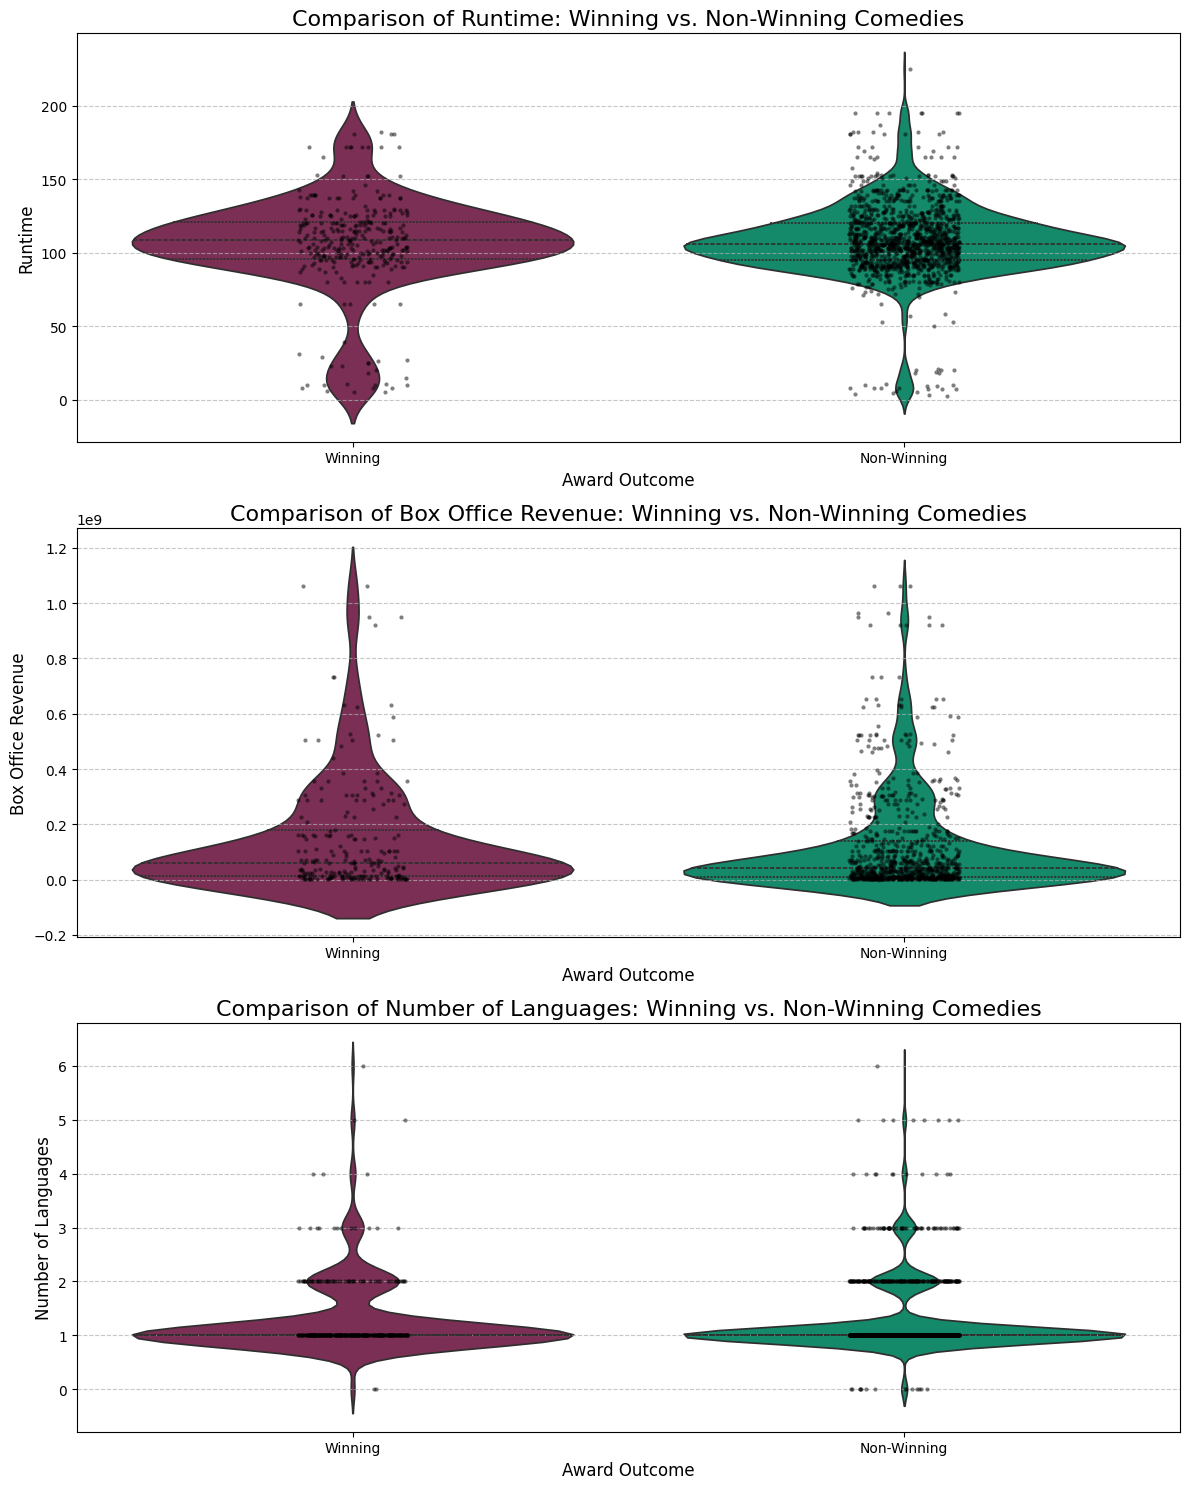

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]
winning_comedies = comedy_movies[comedy_movies['winner'] == True]
non_winning_comedies = comedy_movies[comedy_movies['winner'] == False]

winning_comedies['num_languages'] = winning_comedies['languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
non_winning_comedies['num_languages'] = non_winning_comedies['languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)

comedy_features = pd.DataFrame({
    'Runtime': winning_comedies['runtime'].tolist() + non_winning_comedies['runtime'].tolist(),
    'Box Office Revenue': winning_comedies['box_office_revenue'].tolist() + non_winning_comedies['box_office_revenue'].tolist(),
    'Number of Languages': winning_comedies['num_languages'].tolist() + non_winning_comedies['num_languages'].tolist(),
    'Winner': ['Winning'] * len(winning_comedies) + ['Non-Winning'] * len(non_winning_comedies)
})

features_to_compare = ['Runtime', 'Box Office Revenue', 'Number of Languages'] 
plt.figure(figsize=(12, len(features_to_compare) * 5))


for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(len(features_to_compare), 1, i)
    
    sns.violinplot(data=comedy_features, x='Winner', y=feature, palette=COLOR_PALETTE[6:8], inner='quartile')
    sns.stripplot(data=comedy_features, x='Winner', y=feature, color='k', alpha=0.5, size=3, jitter=True)
    
    plt.title(f'Comparison of {feature}: Winning vs. Non-Winning Comedies', fontsize=16)
    plt.xlabel('Award Outcome', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

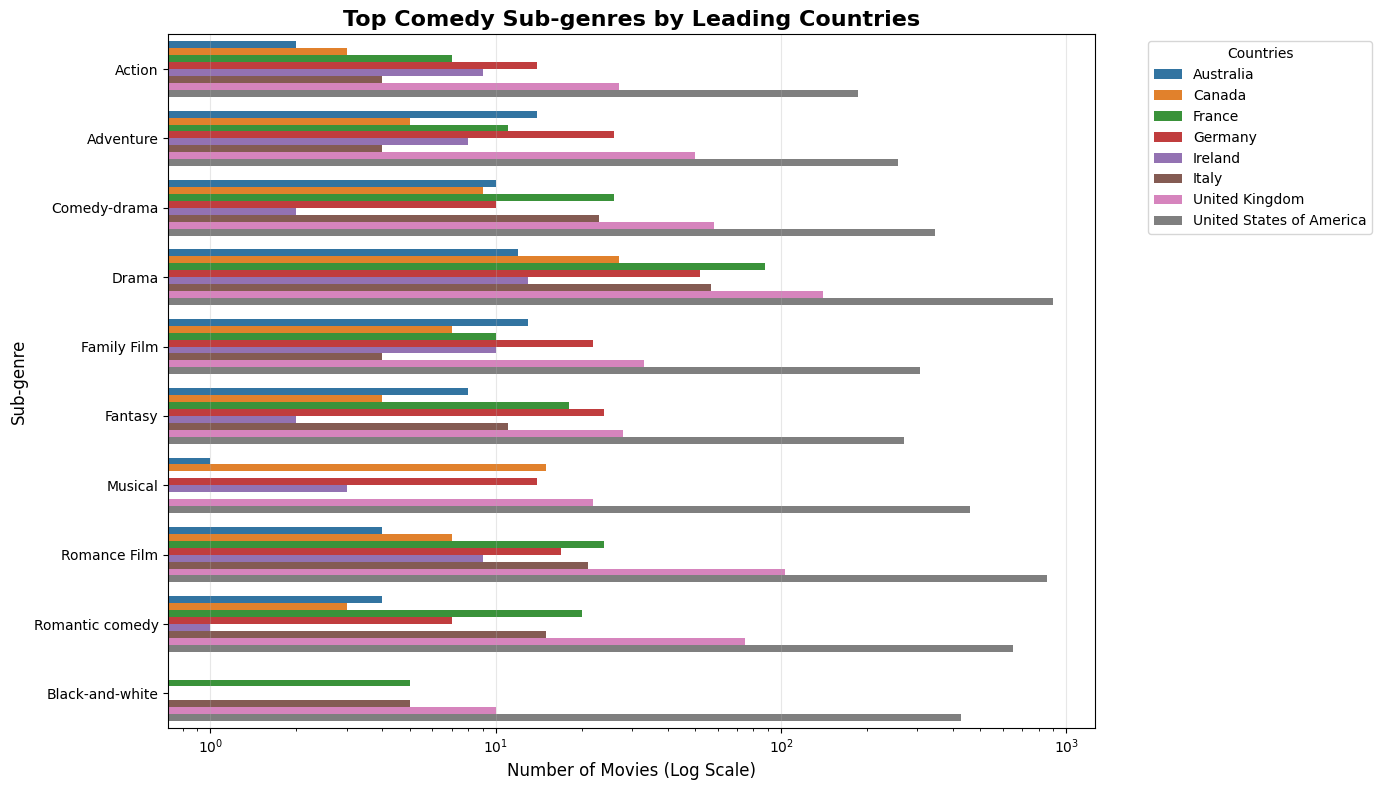

In [160]:
comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]
comedy_movies['genres'] = comedy_movies['genres'].apply(lambda g: [genre for genre in g if genre != 'Comedy'])

genre_by_country = comedy_movies.explode('genres').explode('countries').groupby(['countries', 'genres']).size().reset_index(name='Count')

top_genres = genre_by_country.groupby('genres')['Count'].sum().nlargest(10).index
genre_by_country_filtered = genre_by_country[genre_by_country['genres'].isin(top_genres)]

top_countries = genre_by_country_filtered.groupby('countries')['Count'].sum().nlargest(8).index
genre_by_country_filtered = genre_by_country_filtered[genre_by_country_filtered['countries'].isin(top_countries)]

plt.figure(figsize=(14, 8))
sns.barplot(
    data=genre_by_country_filtered, 
    x='Count', y='genres', hue='countries', 
    palette=COLOR_PALETTE, dodge=True
)

plt.title('Top Comedy Sub-genres by Leading Countries', fontsize=16, fontweight='bold')
plt.xlabel('Number of Movies (Log Scale)', fontsize=12)
plt.ylabel('Sub-genre', fontsize=12)
plt.xscale("log")

plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


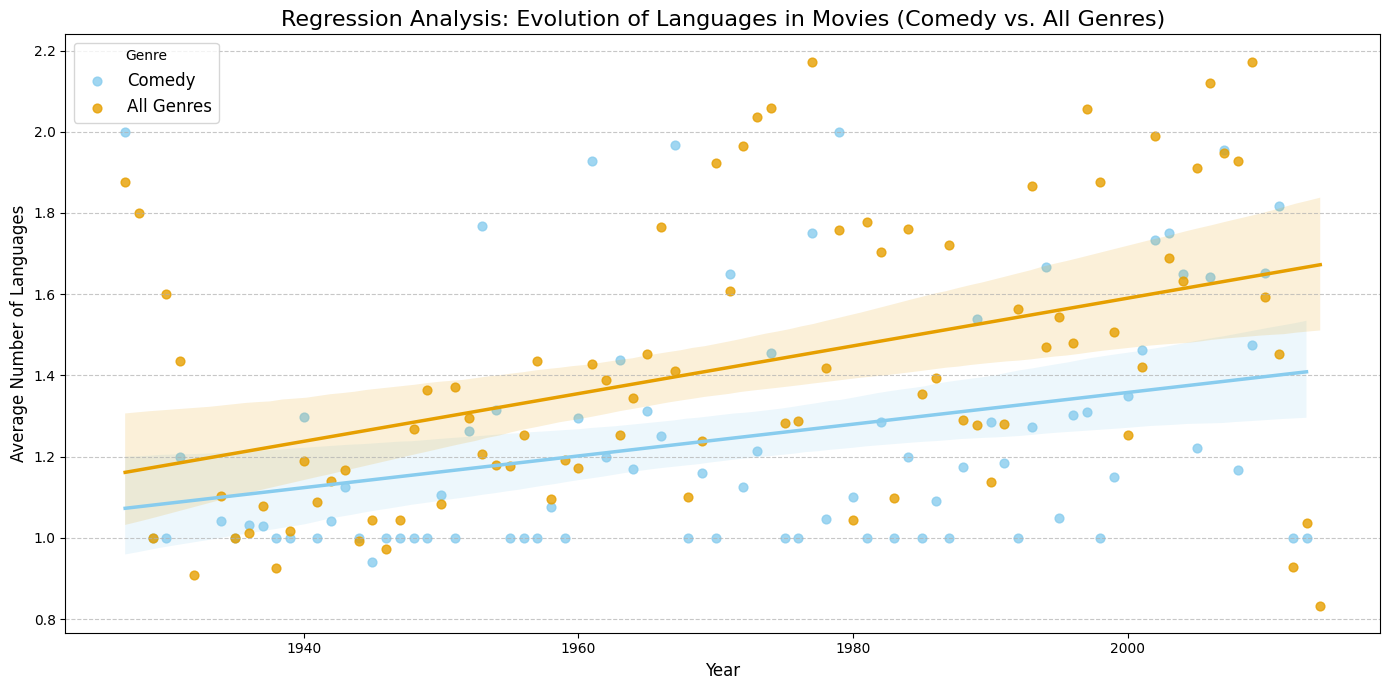

In [86]:
movies_awards['num_languages'] = movies_awards['languages'].apply(len)

comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]

avg_languages_comedy = comedy_movies.groupby(comedy_movies['release_date'].astype(int))['num_languages'].mean().reset_index()
avg_languages_comedy.columns = ['Year', 'Average Number of Languages']
avg_languages_comedy['Genre'] = 'Comedy'

avg_languages_all = movies_awards.groupby(movies_awards['release_date'].astype(int))['num_languages'].mean().reset_index()
avg_languages_all.columns = ['Year', 'Average Number of Languages']
avg_languages_all['Genre'] = 'All Genres'

language_trend_comparison = pd.concat([avg_languages_comedy, avg_languages_all])

plt.figure(figsize=(14, 7))
sns.regplot(
    data=language_trend_comparison[language_trend_comparison['Genre'] == 'Comedy'],
    x='Year', y='Average Number of Languages', scatter=True, label='Comedy', color=COLOR_PALETTE[1], scatter_kws={'s': 40}, line_kws={'lw': 2.5}
)
sns.regplot(
    data=language_trend_comparison[language_trend_comparison['Genre'] == 'All Genres'],
    x='Year', y='Average Number of Languages', scatter=True, label='All Genres', color=COLOR_PALETTE[2], scatter_kws={'s': 40}, line_kws={'lw': 2.5}
)

plt.title('Regression Analysis: Evolution of Languages in Movies (Comedy vs. All Genres)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Number of Languages', fontsize=12)
plt.legend(title='Genre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

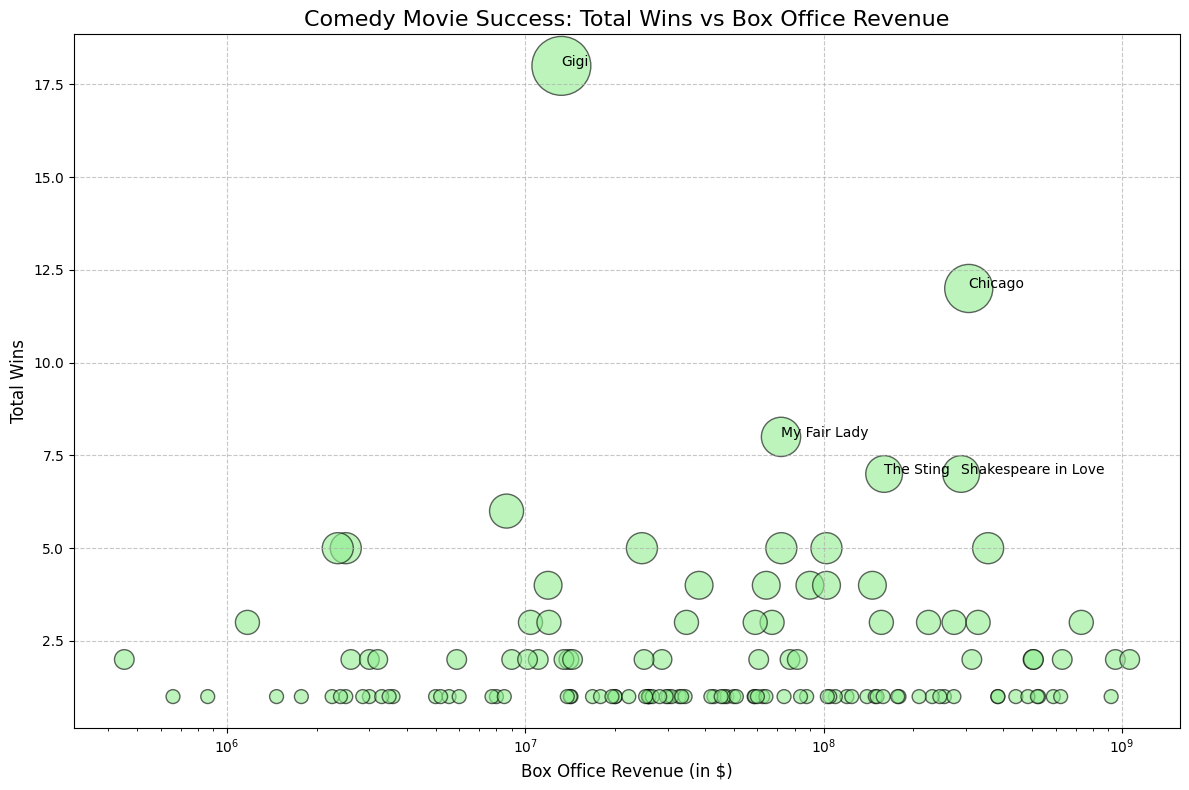

In [125]:
comedy_movies = movies_awards[
    (movies_awards['genres'].apply(lambda x: 'Comedy' in x if isinstance(x, list) else False)) & 
    (movies_awards['winner'] == True)
]

comedy_success_data = comedy_movies.groupby('title').agg({
    'box_office_revenue': 'mean',  
    'winner': 'count'              
}).reset_index().rename(columns={'winner': 'total_wins'})

comedy_success_data = comedy_success_data.dropna(subset=['box_office_revenue'])

plt.figure(figsize=(12, 8))
bubble = plt.scatter(
    x=comedy_success_data['box_office_revenue'],
    y=comedy_success_data['total_wins'],
    s=comedy_success_data['total_wins'] * 100,  
    alpha=0.6,
    color='lightgreen',
    edgecolors='k'
)

plt.title("Comedy Movie Success: Total Wins vs Box Office Revenue", fontsize=16)
plt.xlabel("Box Office Revenue (in $)", fontsize=12)
plt.ylabel("Total Wins", fontsize=12)
plt.xscale("log")  
plt.grid(True, linestyle='--', alpha=0.7)

top_comedy_movies = comedy_success_data.nlargest(5, 'total_wins')
for i, row in top_comedy_movies.iterrows():
    plt.text(row['box_office_revenue'], row['total_wins'], row['title'], fontsize=10)

plt.tight_layout()
plt.show()

Mayde we can put this graph in another part

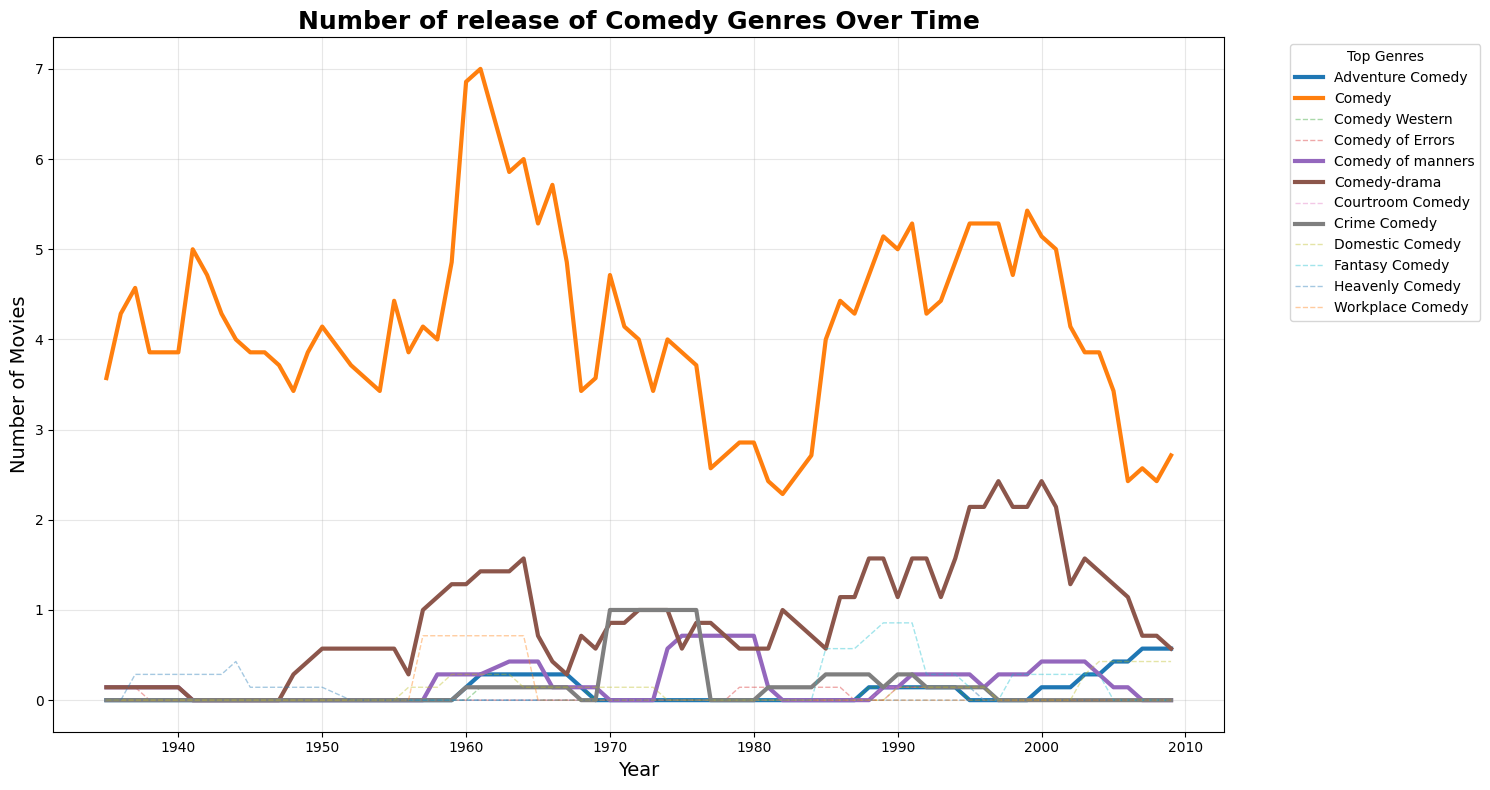

In [52]:
comedy_movies['genres'] = comedy_movies['genres'].apply(lambda x: x if isinstance(x, list) else [])
movies_exploded_genres = comedy_movies.explode('genres')
comedy_genres = movies_exploded_genres[movies_exploded_genres['genres'].str.contains('Comedy', na=False)]
comedy_genres_count = comedy_genres.groupby(['release_date', 'genres']).size().reset_index(name='count')
comedy_genres_pivot = comedy_genres_count.pivot(index='release_date', columns='genres', values='count').fillna(0)

smoothed_comedy_genres = comedy_genres_pivot.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize=(15, 8))

top_genres = comedy_genres_pivot.sum().sort_values(ascending=False).head(5).index
for genre in smoothed_comedy_genres.columns:
    if genre in top_genres:
        smoothed_comedy_genres[genre].plot(ax=ax, linewidth=3, label=genre) 
    else:
        smoothed_comedy_genres[genre].plot(ax=ax, linewidth=1, alpha=0.4, label=genre, linestyle='--')  

plt.title("Number of release of Comedy Genres Over Time", fontsize=18, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Movies", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title="Top Genres", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.show()


<Figure size 1500x800 with 0 Axes>

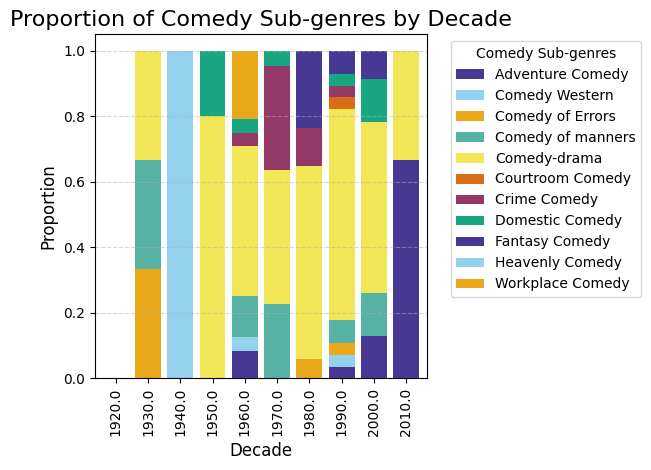

In [144]:
comedy_genres_count['decade'] = (comedy_genres_count['release_date'] // 10) * 10
decade_genre_counts = comedy_genres_count.groupby(['decade', 'genres'])['count'].sum().reset_index()
decade_genre_pivot = decade_genre_counts.pivot(index='decade', columns='genres', values='count').fillna(0)
if 'Comedy' in decade_genre_pivot.columns:
    decade_genre_pivot = decade_genre_pivot.drop(columns='Comedy')
decade_proportion = decade_genre_pivot.div(decade_genre_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(15, 8))

decade_proportion.plot(
    kind='bar',
    stacked=True,
    color=COLOR_PALETTE[:len(decade_proportion.columns)], 
    alpha=0.9,
    width=0.8
)

plt.title("Proportion of Comedy Sub-genres by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Comedy Sub-genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [157]:
example_movies = comedy_genres[['genres', 'title']].dropna()
example_per_genre = example_movies.groupby('genres')['title'].first().reset_index()
print("Example Movies for Each Comedy Sub-genre:\n")
for _, row in example_per_genre.iterrows():
    print(f"Sub-genre: {row['genres']} -> Example Movie: {row['title']}")

Example Movies for Each Comedy Sub-genre:

Sub-genre: Adventure Comedy -> Example Movie: Finding Nemo
Sub-genre: Comedy -> Example Movie: Alexander's Ragtime Band
Sub-genre: Comedy Western -> Example Movie: Cat Ballou
Sub-genre: Comedy of Errors -> Example Movie: Mrs. Doubtfire
Sub-genre: Comedy of manners -> Example Movie: Lost in Translation
Sub-genre: Comedy-drama -> Example Movie: Harry and Tonto
Sub-genre: Courtroom Comedy -> Example Movie: My Cousin Vinny
Sub-genre: Crime Comedy -> Example Movie: Prizzi's Honor
Sub-genre: Domestic Comedy -> Example Movie: Lovers and Other Strangers
Sub-genre: Fantasy Comedy -> Example Movie: The Fisher King
Sub-genre: Heavenly Comedy -> Example Movie: The Bishop's Wife
Sub-genre: Workplace Comedy -> Example Movie: The Apartment
